In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

plt.style.use('ggplot')
# pd.set_option('display.max_rows', None)

In [2]:
file_path ='data/0804 大社課 TXF 1m.csv'
df = pd.read_csv(file_path)
df.head(3)


Unnamed: 0             datetime    Open    High     Low   Close  Volume  \
0           0  2010-01-04 08:46:00  8203.0  8208.0  8184.0  8187.0    1108   
1           1  2010-01-04 08:47:00  8187.0  8195.0  8186.0  8193.0     429   
2           2  2010-01-04 08:48:00  8194.0  8201.0  8193.0  8200.0     419   

         Date      Time  
0  2010-01-04  08:46:00  
1  2010-01-04  08:47:00  
2  2010-01-04  08:48:00

In [3]:
'''
！資料整理！
resample的bug?
交易時間需整除，不然最後一根K看的長度會不一樣 => 1m, 3m, 5m, 10m, 15m, 30m, 60m, 1D
reample 1H，通常是從00:00記錄到00:00
resample後，沒有交易的時段會有NAN
如果用K棒數來數分K：
有時候夜盤沒交易的時段沒有值，會算錯根數
結算日早盤交易時間少15分鐘，會算到夜盤
resample時間前歸後歸、開區間/閉區間的問題 (resample 參數中的 'close', 'label')
台指期特殊處理
台指期通常慣用結束時間紀錄分K (幣圈是使用開始時間)
2017-5開始有夜盤
分成日盤、日夜盤兩種交易時間
結算日早盤交易時間少15分鐘
每月第三個禮拜三為結算日
交易時段：
日盤：8:46~13:45
夜盤：15:01~5:00
'''

"\n！資料整理！\nresample的bug?\n交易時間需整除，不然最後一根K看的長度會不一樣 => 1m, 3m, 5m, 10m, 15m, 30m, 60m, 1D\nreample 1H，通常是從00:00記錄到00:00\nresample後，沒有交易的時段會有NAN\n如果用K棒數來數分K：\n有時候夜盤沒交易的時段沒有值，會算錯根數\n結算日早盤交易時間少15分鐘，會算到夜盤\nresample時間前歸後歸、開區間/閉區間的問題 (resample 參數中的 'close', 'label')\n台指期特殊處理\n台指期通常慣用結束時間紀錄分K (幣圈是使用開始時間)\n2017-5開始有夜盤\n分成日盤、日夜盤兩種交易時間\n結算日早盤交易時間少15分鐘\n每月第三個禮拜三為結算日\n交易時段：\n日盤：8:46~13:45\n夜盤：15:01~5:00\n"

In [4]:
df.index = pd.to_datetime(df['datetime'])
df.sort_index(inplace=True)
df = df.drop(columns=['Date', 'Time', 'datetime', 'Unnamed: 0'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.hour
df.head(3)

open    high     low   close  volume  Hour
datetime                                                         
2010-01-04 08:46:00  8203.0  8208.0  8184.0  8187.0    1108     8
2010-01-04 08:47:00  8187.0  8195.0  8186.0  8193.0     429     8
2010-01-04 08:48:00  8194.0  8201.0  8193.0  8200.0     419     8

Text(0.5, 1.0, 'Volume History')

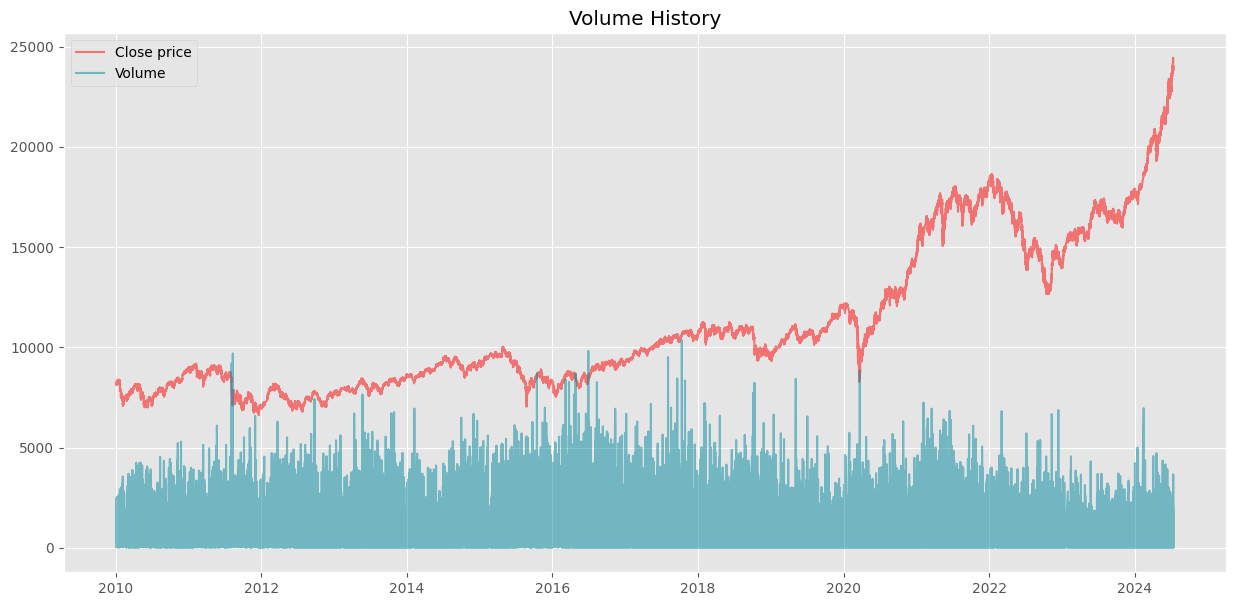

In [5]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History')

Text(0.5, 1.0, 'Volume of each hours')

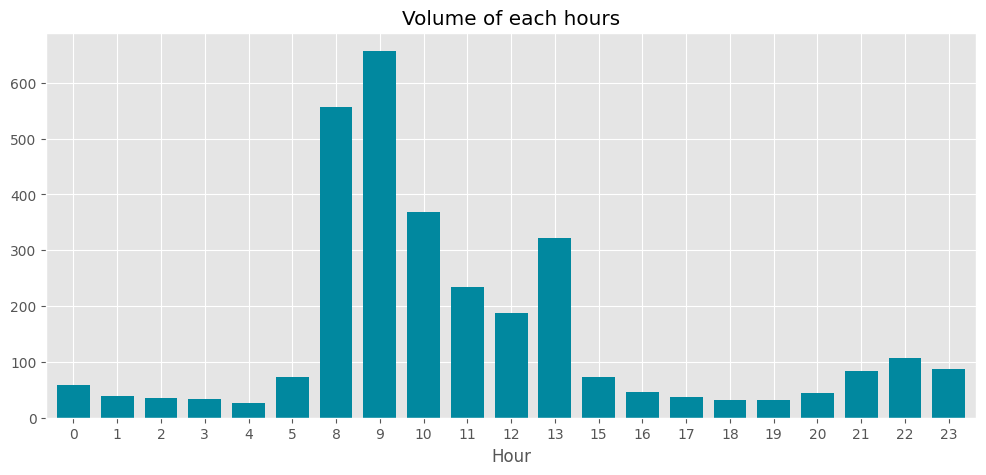

In [6]:
data = df[(df.index >= '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours')

Text(0.5, 1.0, 'Volume of each hours')

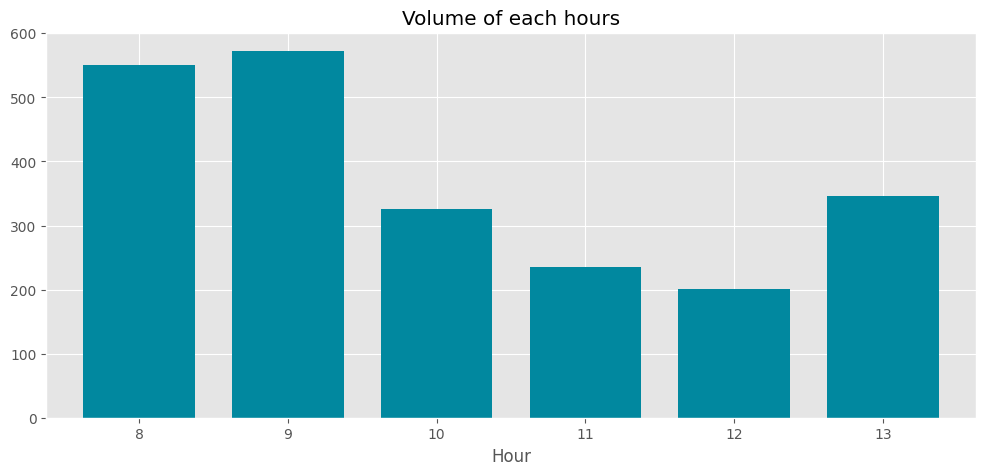

In [7]:
data = df[(df.index < '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours')

In [8]:
'''
!reample!
注意
台指期的 9:01 是指 9:00 ~ 9:01
因此 9:03 的 3分K 應為 9:01 ~ 9:03
label='left' 顯示方式轉為整點開始
日K 需要特別處理
時間直接減 8hr，再做 resample 即可
時間要往後加一天，才不會用到未來資料
8/8 日K 會用到 8/9 的 5:00
計算 8/8 當天報酬率，是從 8/8 8:45 ~ 8/9 5:00
使用外部資料需特別小心，因此通常會加一天處理
2017-5 之後才有夜盤 (日K 多了 14 小時)
日K 資料若包含日夜盤，通常會回測 2017-5 之後的資料，不然K棒的資訊含量不同
使用 2017-5 之前的資料，時間更長，但回測上可能需注意市場結構轉變
或者直接不考慮夜盤計算日K，就不會遇到這些問題了
'''

"\n!reample!\n注意\n台指期的 9:01 是指 9:00 ~ 9:01\n因此 9:03 的 3分K 應為 9:01 ~ 9:03\nlabel='left' 顯示方式轉為整點開始\n日K 需要特別處理\n時間直接減 8hr，再做 resample 即可\n時間要往後加一天，才不會用到未來資料\n8/8 日K 會用到 8/9 的 5:00\n計算 8/8 當天報酬率，是從 8/8 8:45 ~ 8/9 5:00\n使用外部資料需特別小心，因此通常會加一天處理\n2017-5 之後才有夜盤 (日K 多了 14 小時)\n日K 資料若包含日夜盤，通常會回測 2017-5 之後的資料，不然K棒的資訊含量不同\n使用 2017-5 之前的資料，時間更長，但回測上可能需注意市場結構轉變\n或者直接不考慮夜盤計算日K，就不會遇到這些問題了\n"

In [9]:
rule = '3T'
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
Morning.iloc[0:10]

open    high     low   close  volume  Hour
datetime                                                         
2010-01-04 09:01:00  8203.0  8208.0  8184.0  8187.0    1108     8
2010-01-04 09:02:00  8187.0  8195.0  8186.0  8193.0     429     8
2010-01-04 09:03:00  8194.0  8201.0  8193.0  8200.0     419     8
2010-01-04 09:04:00  8200.0  8203.0  8198.0  8200.0     295     8
2010-01-04 09:05:00  8200.0  8201.0  8195.0  8197.0     187     8
2010-01-04 09:06:00  8198.0  8200.0  8195.0  8197.0     219     8
2010-01-04 09:07:00  8197.0  8200.0  8195.0  8196.0     207     8
2010-01-04 09:08:00  8196.0  8199.0  8195.0  8197.0     167     8
2010-01-04 09:09:00  8197.0  8198.0  8196.0  8196.0     124     8
2010-01-04 09:10:00  8197.0  8198.0  8197.0  8198.0      87     8

In [10]:
# 確認 9:03 及 9:06 的 open 是 9:01 及 9:04 的 open
Morning.resample(rule=rule, closed='right', label='right').last()[['close']].iloc[0:3]

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/3197111766.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Morning.resample(rule=rule, closed='right', label='right').last()[['close']].iloc[0:3]


close
datetime                   
2010-01-04 09:03:00  8200.0
2010-01-04 09:06:00  8197.0
2010-01-04 09:09:00  8196.0

In [11]:
# label='left' => 時間轉為左側時間
Morning.resample(rule=rule, closed='left', label='left').last()[['close']].iloc[0:3]

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/299197481.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Morning.resample(rule=rule, closed='left', label='left').last()[['close']].iloc[0:3]


close
datetime                   
2010-01-04 09:00:00  8193.0
2010-01-04 09:03:00  8197.0
2010-01-04 09:06:00  8197.0

In [12]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/968608872.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/968608872.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/968608872.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/968608872.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d4 = Morning.resample(rule=rul

open    high     low   close  volume
datetime                                                   
2010-01-04 08:45:00  8203.0  8211.0  8181.0  8187.0   17247
2010-01-04 09:45:00  8187.0  8188.0  8101.0  8165.0   31531
2010-01-04 10:45:00  8167.0  8180.0  8158.0  8172.0    8859
2010-01-04 11:45:00  8172.0  8207.0  8167.0  8197.0   12329
2010-01-04 12:45:00  8198.0  8200.0  8165.0  8166.0   13915

In [13]:
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()
df_Night.head()

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1093008970.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1093008970.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1093008970.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1093008970.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  d4 = Night.resample(rule=rule, c

open     high      low    close  volume
datetime                                                       
2017-05-15 15:00:00  10023.0  10034.0  10020.0  10033.0     925
2017-05-15 16:00:00  10032.0  10032.0  10028.0  10030.0     300
2017-05-15 17:00:00  10030.0  10030.0  10026.0  10027.0     137
2017-05-15 18:00:00  10026.0  10028.0  10025.0  10027.0     148
2017-05-15 19:00:00  10028.0  10030.0  10028.0  10030.0      40

In [14]:
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)
df_Day.head()

open    high     low   close  volume
datetime                                                   
2010-01-04 08:45:00  8203.0  8211.0  8181.0  8187.0   17247
2010-01-04 09:45:00  8187.0  8188.0  8101.0  8165.0   31531
2010-01-04 10:45:00  8167.0  8180.0  8158.0  8172.0    8859
2010-01-04 11:45:00  8172.0  8207.0  8167.0  8197.0   12329
2010-01-04 12:45:00  8198.0  8200.0  8165.0  8166.0   13915

In [15]:
# ### 特例：日K處理 ###
# day = df.loc['2017-5-15':].copy()
# df_day.index = df_day.index - dt.timedelta(hours=8)

# d1 = df_day.resample(rule='1D', closed='right', label='left').first()[['open']]
# d2 = df_day.resample(rule='1D', closed='right', label='left').max()[['high']]
# d3 = df_day.resample(rule='1D', closed='right', label='left').min()[['low']]
# d4 = df_day.resample(rule='1D', closed='right', label='left').last()[['close']]
# d5 = df_day.resample(rule='1D', closed='right', label='left').sum()[['volume']]

# df_day = pd.concat([d1,d2,d3,d4,d5], axis=1)
# df_day = df_day.dropna()
# df_day.index = df_day.index + dt.timedelta(days=1) ##回測時結算日也要加一天
# df_day.tail()

In [16]:
'''選擇回測資料'''

'選擇回測資料'

In [17]:
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.hour

In [18]:
trainData = df_Morning[(df_Morning.index >= '2010-01-01 00:00:00') & (df_Morning.index <= '2022-06-30 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2022-07-01 00:00:00') & (df_Morning.index <= '2024-06-30 00:00:00')].copy()

In [19]:
'''取得結算日資料'''

'取得結算日資料'

In [20]:
file_path ='data/0804 Settlement Date.csv'
settlementDate_ = pd.read_csv(file_path)
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

settlementDate   futures  settlementPrice
0       2024/07/26  202407W4            22069
1       2024/07/17    202407            23680
2       2024/07/10  202407W2            23996
3       2024/07/03  202407W1            23138
4       2024/06/26  202406W4            22965
..             ...       ...              ...
740     1999/01/21    199901             6332
741     1998/12/17    199812             6695
742     1998/11/19    199811             7185
743     1998/10/22    199810             7068
744     1998/09/17    199809             7036

[745 rows x 3 columns]

In [21]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]

In [22]:
len(list(settlementDate_[bool_]['futures']))

311

In [23]:
12*25 + 4 + 7 # 1999~2023 共 25 年＊12個月，再加上 1998 年的9,10,11,12月期貨和今年的 1,2,3,4,5,6,7月期貨

311

In [24]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [25]:
'''
！回測假設！
換月轉倉：結算日當天直接平倉
進場限制：結算日當天不進場
報酬計算：200 * 點數
手續費+滑價：單邊 600元
'''

'\n！回測假設！\n換月轉倉：結算日當天直接平倉\n進場限制：結算日當天不進場\n報酬計算：200 * 點數\n手續費+滑價：單邊 600元\n'

In [26]:
#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04

#指標計算
# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']

trainData.tail(3)

open     high      low    close  volume  Hour  \
datetime                                                                
2022-06-29 10:45:00  15083.0  15091.0  14994.0  15034.0   16523    10   
2022-06-29 11:45:00  15036.0  15066.0  15015.0  15051.0   11264    11   
2022-06-29 12:45:00  15051.0  15058.0  15007.0  15019.0   17675    12   

                               MA         STD        upLine      downLine  
datetime                                                                   
2022-06-29 10:45:00  15186.133333  130.383975  15381.709296  14990.557371  
2022-06-29 11:45:00  15190.466667  124.190445  15376.752334  15004.180999  
2022-06-29 12:45:00  15187.866667  127.525273  15379.154576  14996.578757

In [27]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

#翻譯蒟蒻
# date_arr = []
# for i in time_arr:
#     date_arr.append(pd.to_datetime(i).date())

In [28]:
'''做多'''

'做多'

Buy Price: 8335.0, time: 2010-01-07T08:45:00.000000000
Sell Price: 8240.0, time: 2010-01-13T09:45:00.000000000
Trade completed

Buy Price: 8343.0, time: 2010-01-15T09:45:00.000000000
Sell Price: 8277.0, time: 2010-01-19T10:45:00.000000000
Trade completed

Buy Price: 7310.0, time: 2010-02-09T10:45:00.000000000
Sell Price: 7574.0, time: 2010-02-22T12:45:00.000000000
Trade completed

Buy Price: 7553.0, time: 2010-03-01T10:45:00.000000000
Sell Price: 7525.0, time: 2010-03-04T11:45:00.000000000
Trade completed

Buy Price: 7681.0, time: 2010-03-05T09:45:00.000000000
Sell Price: 7634.0, time: 2010-03-15T10:45:00.000000000
Trade completed

Buy Price: 7849.0, time: 2010-03-18T09:45:00.000000000
Sell Price: 7788.0, time: 2010-03-22T09:45:00.000000000
Trade completed

Buy Price: 7901.0, time: 2010-03-26T11:45:00.000000000
Sell Price: 7940.0, time: 2010-04-01T08:45:00.000000000
Trade completed

Buy Price: 8018.0, time: 2010-04-01T09:45:00.000000000
Sell Price: 8059.0, time: 2010-04-08T12:45:00.000

<Axes: xlabel='datetime'>

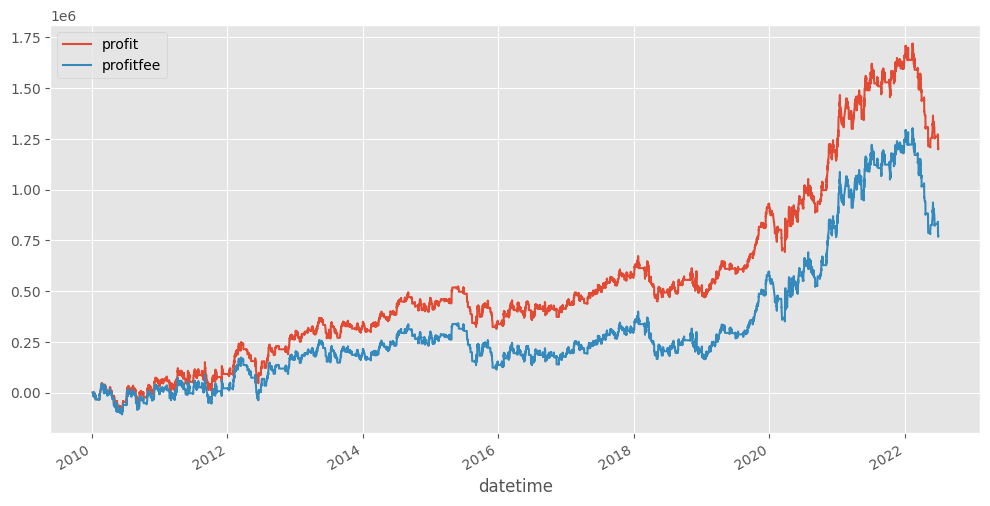

In [29]:
#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

#開始交易流程
for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    #做多的狀態
    if BS == 'B':
      # 停利停損條件
      stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
      stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        #確認進場&相關設定
        if entryLong and entryCondition:
            #更改狀態至做多
            BS = 'B'
            #紀錄進場時間
            t = i+1
            buy.append(t)
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    #進場開始計算未實現損益
    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)

            #紀錄出場時間
            sell.append(i+1)

            #重置交易狀態
            BS = None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()


            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))

In [30]:
'''做空'''

'做空'

sell short at 2010-01-04T09:45:00.000000000
buytocover at 2010-01-04T10:45:00.000000000
trade completed

sell short at 2010-01-04T11:45:00.000000000
buytocover at 2010-01-04T12:45:00.000000000
trade completed

sell short at 2010-01-05T08:45:00.000000000
buytocover at 2010-01-05T09:45:00.000000000
trade completed

sell short at 2010-01-05T10:45:00.000000000
buytocover at 2010-01-05T11:45:00.000000000
trade completed

sell short at 2010-01-05T12:45:00.000000000
buytocover at 2010-01-06T08:45:00.000000000
trade completed

sell short at 2010-01-06T09:45:00.000000000
buytocover at 2010-01-06T10:45:00.000000000
trade completed

sell short at 2010-01-06T11:45:00.000000000
buytocover at 2010-01-06T12:45:00.000000000
trade completed

sell short at 2010-01-07T08:45:00.000000000
buytocover at 2010-01-07T09:45:00.000000000
trade completed

sell short at 2010-01-07T10:45:00.000000000
buytocover at 2010-01-07T11:45:00.000000000
trade completed

sell short at 2010-01-07T12:45:00.000000000
buytocover 

<Axes: xlabel='datetime'>

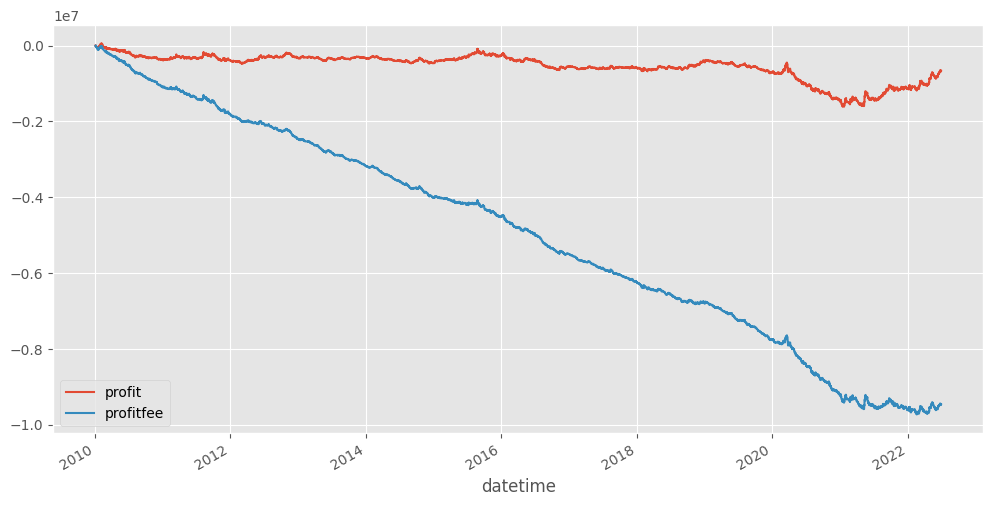

In [31]:
BS = None
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = "Put your answer in the blank!"
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = "Put your answer in the blank!"
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("sell short at {}".format(time_arr[t]))


    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("buytocover at {}".format(time_arr[i+1]))
            print("trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))

In [32]:
'''多空都做'''

'多空都做'

Enter Long Position
Buy Price: 8335.0, time: 2010-01-07T08:45:00.000000000
Sell Price: 8240.0, time: 2010-01-13T09:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 8221.0, time: 2010-01-13T10:45:00.000000000
Buycover Price: 8343.0, time: 2010-01-15T09:45:00.000000000
Trade completed

Enter Long Position
Buy Price: 8379.0, time: 2010-01-15T11:45:00.000000000
Sell Price: 8277.0, time: 2010-01-19T10:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 8260.0, time: 2010-01-19T11:45:00.000000000
Buycover Price: 8240.0, time: 2010-01-20T12:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 8126.0, time: 2010-01-21T10:45:00.000000000
Buycover Price: 7747.0, time: 2010-01-26T10:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 7675.0, time: 2010-01-26T11:45:00.000000000
Buycover Price: 7232.0, time: 2010-02-05T09:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 7232.0, time: 2010-02-05T10:45:00.000000000
Buycover Pr

<Axes: xlabel='datetime'>

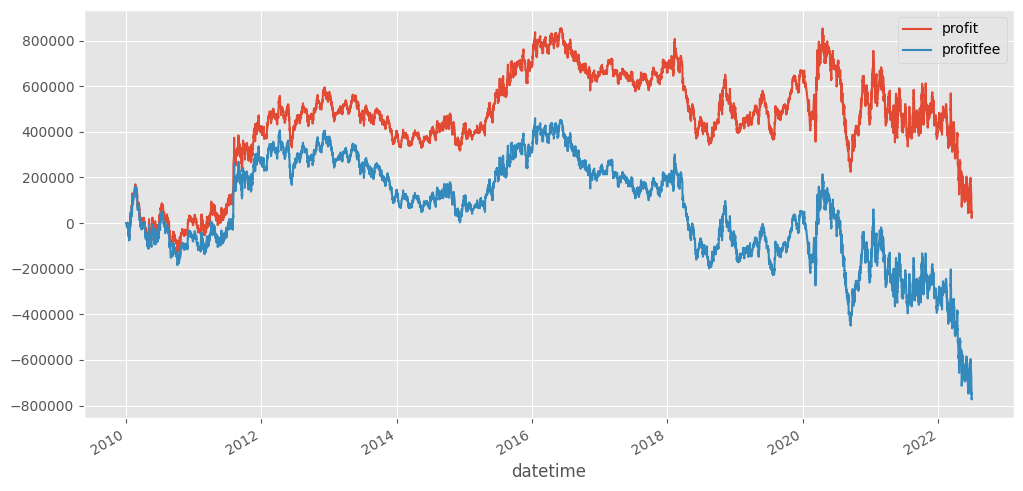

In [33]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entryLong = df_arr[i,3] > df_arr[i,8]
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitShort = df_arr[i,3] <= df_arr[i,9]
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)
            print("Enter Long Position")
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("Enter Short Position")
            print("Sell Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("Buycover Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))

In [34]:
'''做多加碼'''

'做多加碼'

<Axes: xlabel='datetime'>

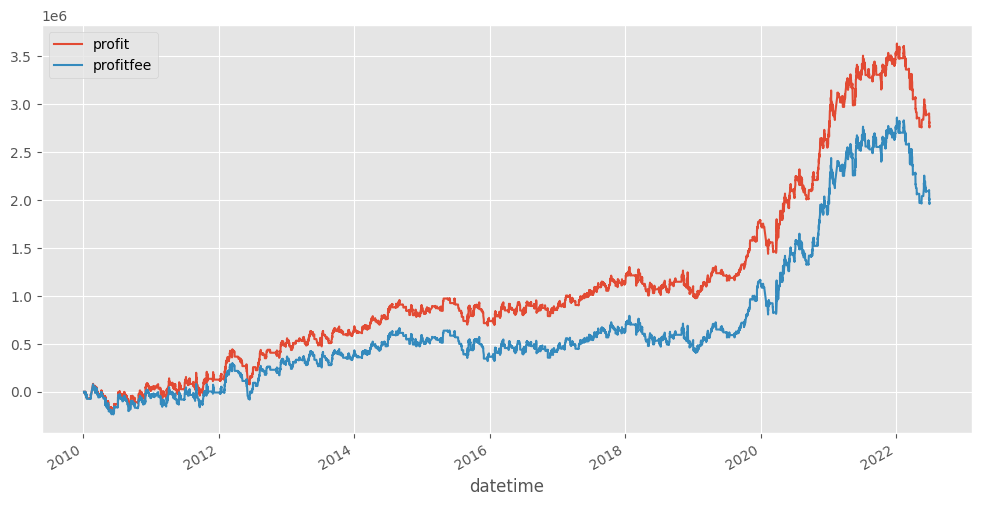

In [35]:
BS = None
Position = 0
buy_price = 0
add_price = 0
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    #當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    #結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
        #做多狀態的加碼條件
        add_condition = df_arr[i, 0] > buy_price

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) & (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            #將第一次進場成本紀錄在這個list中
            cost_list.append(buy_price)
            buy.append(t)

    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)


        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            if Position > 1:
              pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
            else:
              pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
            #重置交易狀態
            BS = None
            #重置部位數量
            Position = 0
            #重置加碼參考價
            buy_price = 0
            #重置加碼成本
            add_price = 0


        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            #將第一次進場成本紀錄在這個list中
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

#             print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
#             print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
#             print()

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))

In [36]:
'''做空加碼'''

'做空加碼'

<Axes: xlabel='datetime'>

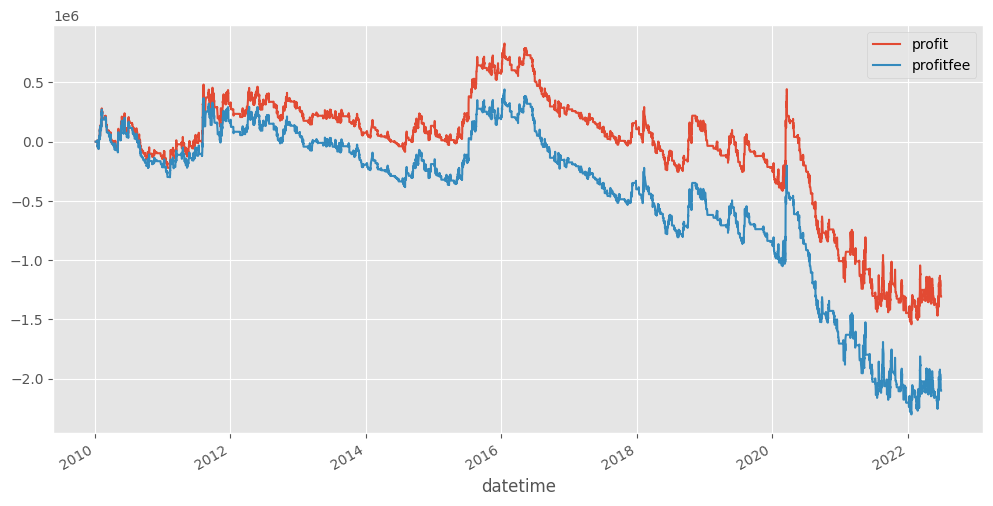

In [37]:
BS = None
Position = 0
sell_price = 0
add_price = 0
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)
        add_condition = df_arr[i, 0] < sell_price

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) and (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            Position = 1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)

    elif BS == 'S':

        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            """
            There is something you need to do
            """
            profit_fee = profit - (feePaid*2 * Position)
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))

In [38]:
'''都做加碼'''

'都做加碼'

<Axes: xlabel='datetime'>

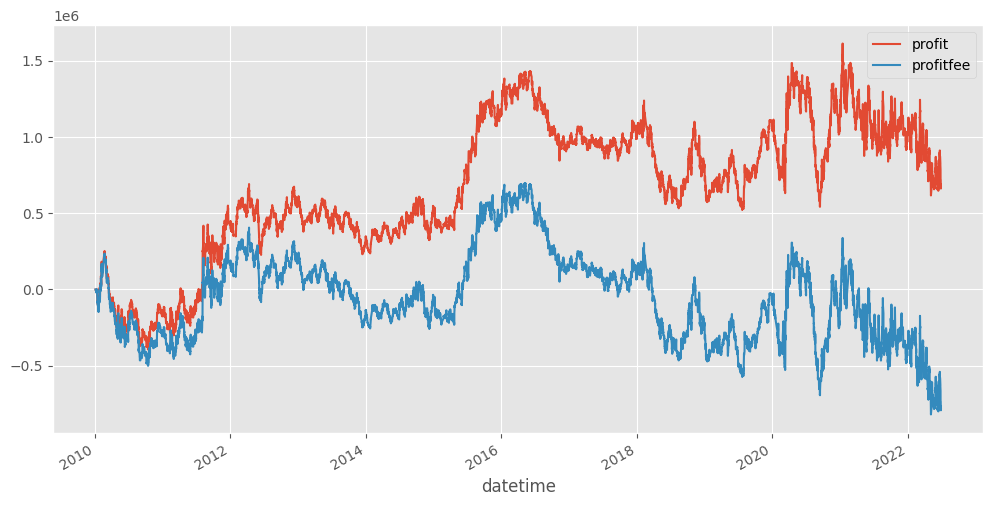

In [39]:
BS = None
Position = 0
buy_price = 0
sell_price = 0
add_price = 0
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    ### 當收盤價跌破布林下軌
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    #當收盤價突破布林上軌
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]

    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
        add_condition = df_arr[i, 0] > buy_price

    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)
        add_condition = df_arr[i, 0] < sell_price


#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) & (Position == 0):
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            cost_list.append(buy_price)
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            Position = 1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)


    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (Position*df_arr[i+1, 0] - np.sum(cost_list))
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            buy_price = 0
            add_price = 0
            cost_list = []

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':

        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (np.sum(cost_list) - Position*df_arr[i+1, 0])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            #Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0
            cost_list = []

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))

In [40]:
'''
績效呈現
1.基本指標
2.時間損益
3.損益分布
4.quantstat套件
'''

'\n績效呈現\n1.基本指標\n2.時間損益\n3.損益分布\n4.quantstat套件\n'

In [41]:
import seaborn as sns
import matplotlib.pyplot as py
plt.style.use('ggplot')

In [42]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy) + len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

Profit :  -786600.0
Return :  -0.7866
Max DrawDown :  0.893286219081272
Caimar Ratio :  -0.8805688291139241
Trade Times :  1030
Win Rate :  0.3328313253012048
Profit Factor :  0.9581315136740581


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2466104180.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022],
      dtype='int32', name='datetime')


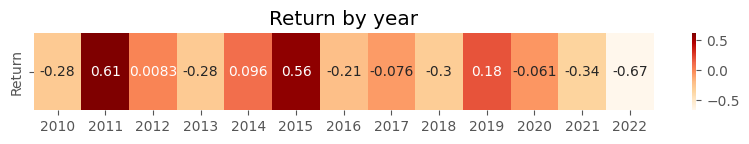


           Jan       Feb       Mar       Apr       May       Jun       Jul  \
2010 -0.006600  0.192810 -0.264970 -0.136585  0.085731  0.034659 -0.015621   
2011 -0.156060 -0.039290  0.284180 -0.096320 -0.023353 -0.007059  0.039249   
2012 -0.057633  0.157951 -0.067732  0.031972 -0.056418 -0.104768  0.059059   
2013 -0.152141  0.058698  0.072561 -0.029645 -0.047261 -0.035137 -0.021785   
2014 -0.068334  0.012363  0.003714  0.007576 -0.018531 -0.032281  0.011497   
2015 -0.102300 -0.028585  0.021644  0.070977  0.031059  0.190353  0.183297   
2016  0.118698 -0.071561  0.032691  0.025112  0.046595 -0.131545 -0.008002   
2017 -0.004158  0.037334 -0.046508 -0.026243 -0.042882 -0.027753 -0.073714   
2018  0.012172  0.031395 -0.066038 -0.187921 -0.181913  0.168802 -0.118709   
2019 -0.264503  0.080263 -0.144391  0.151597  0.168440 -0.226849 -0.144587   
2020 -0.264465 -0.104828  0.308508  0.191588 -0.126802  0.004058 -0.032651   
2021  0.182762  0.024875 -0.230537 -0.091608  0.168234 -0.19573

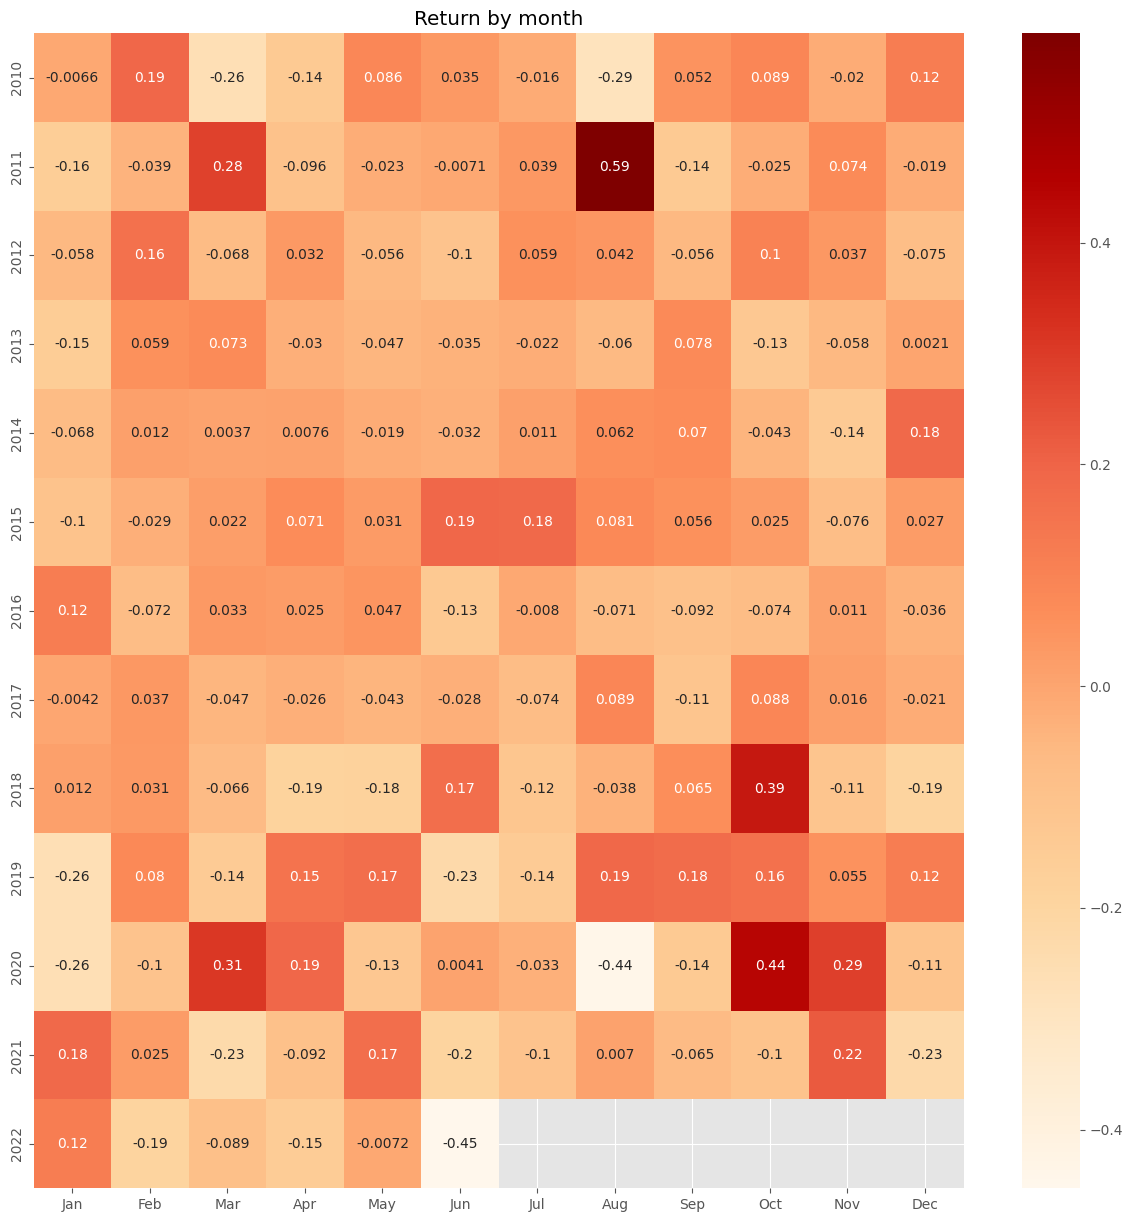

In [43]:
# 時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
year_ret = []
print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)

df = pd.DataFrame({'Return':year_ret},index = years)

# heatmap函式
py.figure(figsize=(10,1))
sns.heatmap(df.transpose(), annot=True, cmap='OrRd')
py.title('Return by year')
py.show()
print('')

# 時間損益(月)
group_data = equity.groupby([equity.index.year, equity.index.month])

month_ret = []
for group, data in group_data:
    month_ret.append(data['equity'].iloc[-1]/data['equity'].iloc[0] - 1)

month_ret_padded = np.append(month_ret, [np.nan] * (13*12 - len(month_ret)))
df = pd.DataFrame(np.array(month_ret_padded).reshape((13,12)), columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = years)

print(df)
py.figure(figsize=(15,15))
sns.heatmap(df, annot=True, cmap='OrRd')
py.title('Return by month')
py.show()

[-0.023875224955009, -0.03345091837975915, -0.024704618689581095, -0.003268765133171913, 0.0708835835589466, 0.10071661237785016, -0.031111725663716814, 0.06599123767798466, -0.039623908663532575, -0.025023047543790332, -0.023704887468371287, -0.025391890141210002, -0.04109052961127055, -0.019747738565422345, -0.03834770299832711, 0.004305432442699759, 0.008605637316038913, -0.015545330182813084, -0.03792341678939617, -0.00928598318484126, -0.052346348072422715, 0.07533902561526871, -0.054538216560509556, -0.04412338930105428, 0.07608986359989302, -0.01988320355951057, -0.018246673069008096, -0.06261355695317959, 0.047906657515442694, 0.029459901800327332, 0.06859651529702292, -0.009943739369357583, -0.009977970714008034, -0.023989396951623592, -0.02432008368200837, 0.013404825737265416, -0.027841052898000505, -0.0032766225582860744, -0.027735562310030396, -0.04187562688064193, -0.012569651418945185, -0.027342747111681644, 0.012253321294982588, 0.050367926922100986, -0.0130928853754940

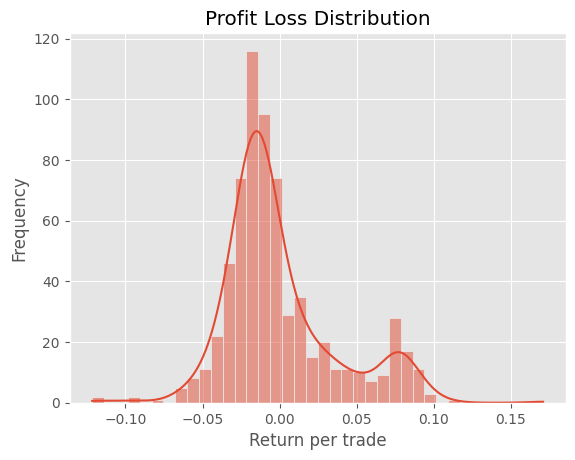

In [44]:
# 損益分布
print(rets)
sns.histplot(rets, kde=True)
py.xlabel('Return per trade')
py.ylabel('Frequency')
py.title('Profit Loss Distribution')
py.show()

Defaulting to user installation because normal site-packages is not writeable
datetime
2010-01-04 09:45:00    0.000000
2010-01-04 10:45:00    0.000000
2010-01-04 11:45:00    0.000000
2010-01-04 12:45:00    0.000000
2010-01-05 08:45:00    0.000000
                         ...   
2022-06-29 08:45:00   -0.122896
2022-06-29 09:45:00    0.061420
2022-06-29 10:45:00   -0.000904
2022-06-29 11:45:00   -0.042534
2022-06-29 12:45:00    0.008507
Name: equity, Length: 15342, dtype: float64


/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


                           Strategy
-------------------------  ----------
Start Period               2010-01-04
End Period                 2022-06-29
Risk-Free Rate             0.0%
Time in Market             83.0%

Cumulative Return          -78.66%
CAGR﹪                     -8.18%

Sharpe                     0.1
Prob. Sharpe Ratio         78.91%
Smart Sharpe               0.1
Sortino                    0.16
Smart Sortino              0.16
Sortino/√2                 0.11
Smart Sortino/√2           0.11
Omega                      1.03

Max Drawdown               -89.33%
Longest DD Days            2242
Volatility (ann.)          35.7%
Calmar                     -0.09
Skew                       3.04
Kurtosis                   71.1

Expected Daily %           -0.01%
Expected Monthly %         -1.02%
Expected Yearly %          -11.2%
Kelly Criterion            1.36%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.68%
Expected Shortfall (cVaR)  -3.68%

Max Consecutive Wins    

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2016-05-10  2022-05-06  2022-06-29  2242    -89.328622        -84.758539
2  2010-02-22  2010-10-14  2011-12-08   655    -59.485270        -57.656199
3  2012-04-11  2014-12-09  2015-08-21  1228    -47.154240        -45.788275
4  2011-12-19  2012-01-30  2012-02-15    58    -16.272235        -15.916473
5  2010-01-11  2010-01-20  2010-01-27    16    -14.659477        -14.639505

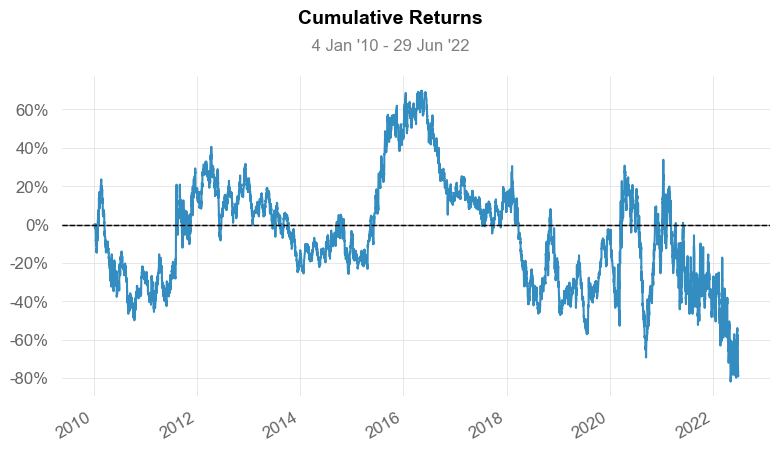

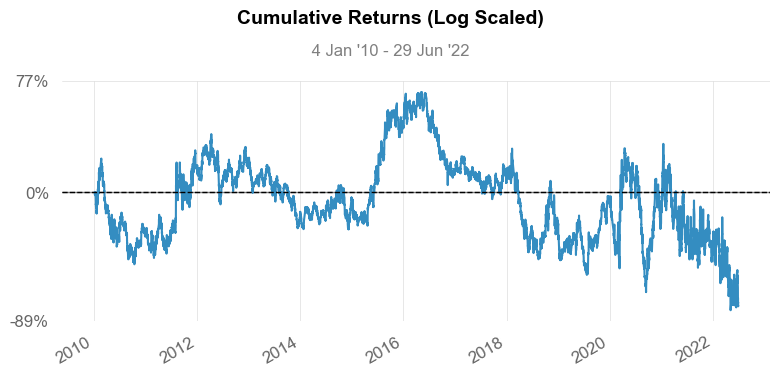

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


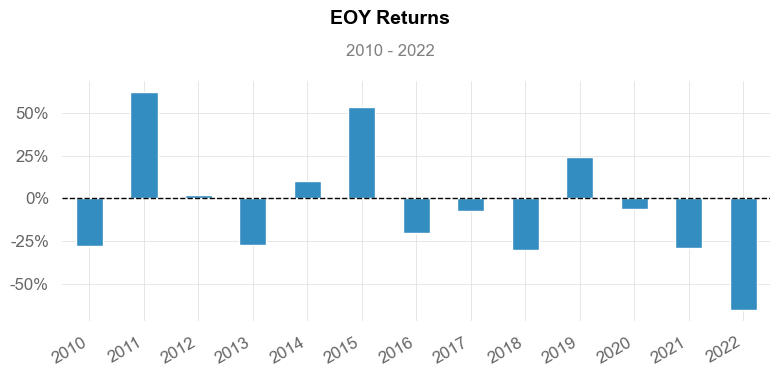

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


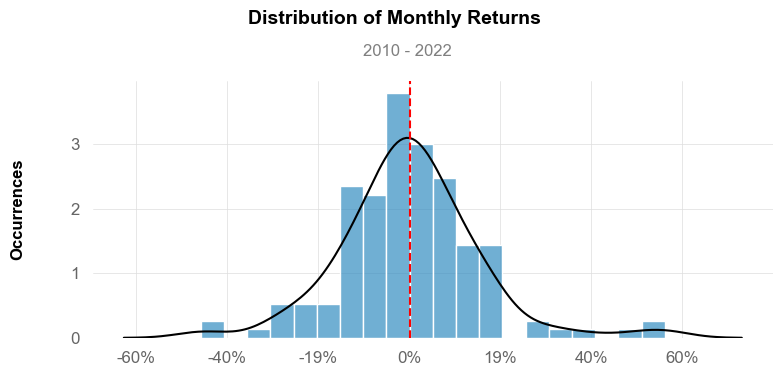

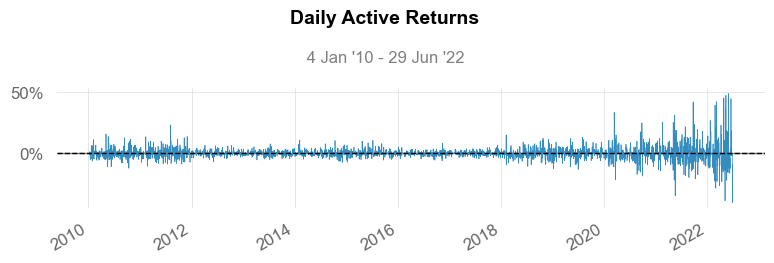

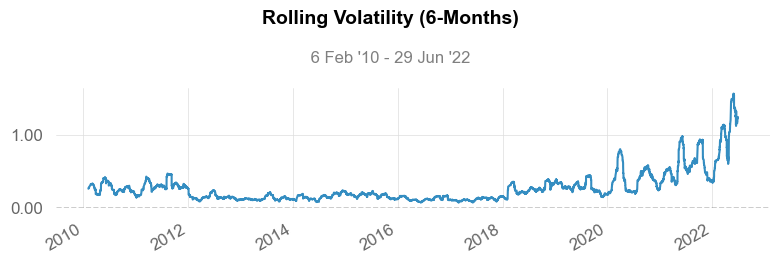

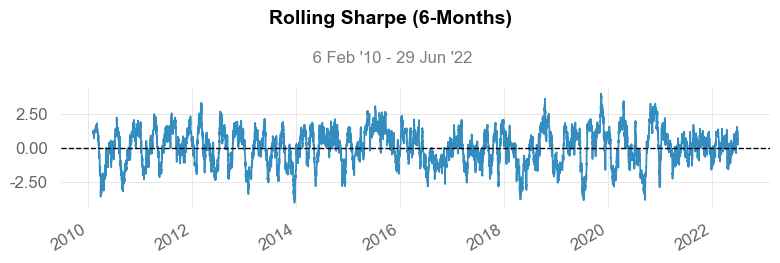

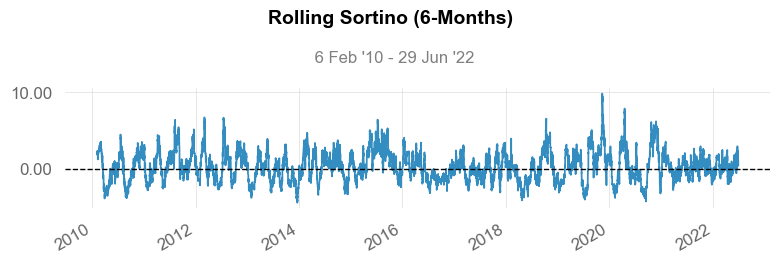

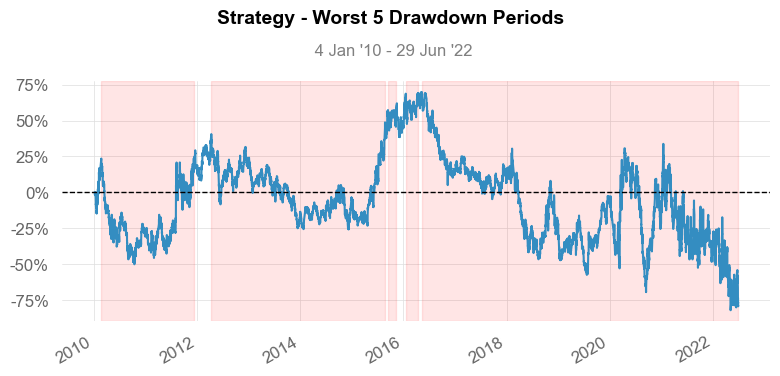

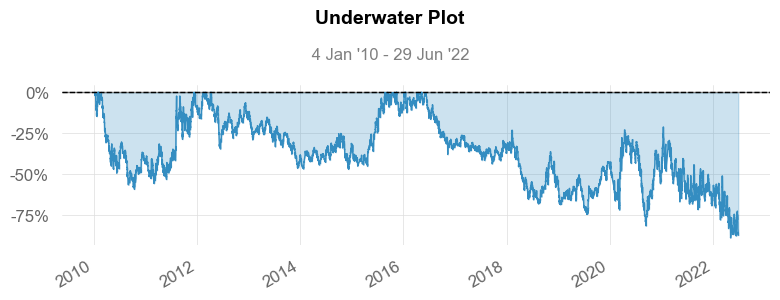

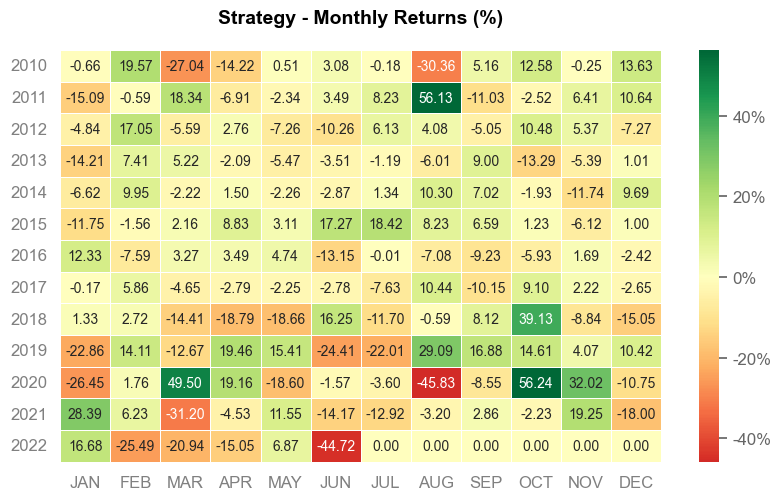

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1019: FutureWarni

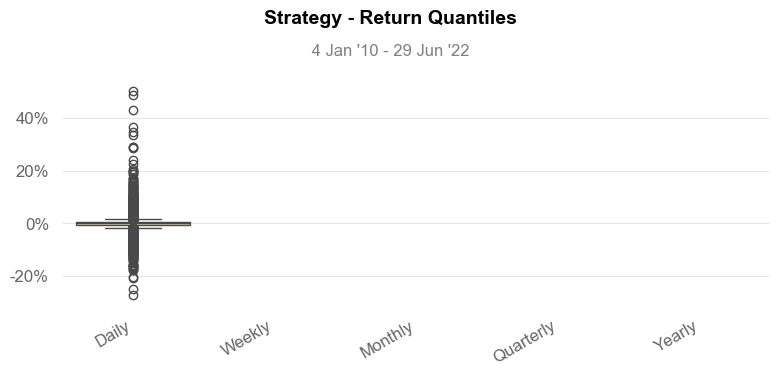

In [45]:
# quantstats回測報表
!pip install quantstats
import quantstats
ret = equity['equity'].pct_change(periods=1).dropna()
print(ret)
quantstats.reports.full(ret)
#quantstats.reports.html(ret,output='stats.html',title='backtest result',download_filename='result.html')

In [46]:
'''參數最佳化'''

'參數最佳化'

In [47]:
optimizationList = []
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5

# 最佳化參數：length & NumStd
for length in range(10,110,10):
    for stdTimes in np.arange(0.5, 3, 0.5):

        stdTimes = np.round(stdTimes,1)

        print('----------')
        print(f'length: {length}')
        print(f'stdTimes: {stdTimes}')

        trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
        trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
        trainData['upLine'] = trainData['MA'] + stdTimes*trainData['STD']
        trainData['downLine'] = trainData['MA'] - stdTimes*trainData['STD']

        #df['ma'] = df['close'].rolling(window=length, center=False).mean()
        #df['std'] = df['close'].rolling(window=length, center=False).std()

        df_arr = np.array(trainData)
        time_arr = np.array(trainData.index)
        date_arr = [pd.to_datetime(i).date() for i in time_arr]

        BS = None
        Position = 0
        buy_price = 0
        add_price = 0
        buy = []
        sell = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
        cost_list = []
        rets = []

        for i in range(len(df_arr)):

            #回測期間最後一天就跳出這個迴圈
            if i == len(df_arr)-1:
                break

            ## 進場邏輯
            #當收盤價突破布林上軌
            entryLong = df_arr[i,3] > df_arr[i,8]
            #結算日不進場
            entryCondition = date_arr[i] not in settlementDate

            ## 出場邏輯
            ### 當收盤價跌破布林下軌
            exitShort = df_arr[i,3] <= df_arr[i,9]
            ### 結算日時放到結算
            exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


            ## 停利停損邏輯
            if BS == 'B':
                stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
                stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
                #做多狀態的加碼條件
                add_condition = df_arr[i, 0] > buy_price

        #     if exitCondition == True:
        #         print(f'{time_arr[i]}')

            if (BS == None) & (Position == 0):

                profit_list.append(0)
                profit_fee_list.append(0)

                if entryLong and entryCondition:
                    BS = 'B'
                    Position = 1
                    t = i+1
                    buy_price = df_arr[i+1, 0]
                    #將第一次進場成本紀錄在這個list中
                    cost_list.append(buy_price)
                    buy.append(t)

            elif BS == 'B':

                profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
                profit_list.append(profit)


                if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    if Position > 1:
                        pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
                    else:
                        pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
                    profit_fee = profit - feePaid*2*Position
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2*Position
                    profit_fee_list_realized.append(profit_fee_realized)
                    rets.append(profit_fee_realized/(200*df_arr[t,0]))
                    #重置交易狀態
                    BS = None
                    #重置部位數量
                    Position = 0
                    #重置加碼參考價
                    buy_price = 0
                    #重置加碼成本
                    add_price = 0


                #確認部位上限&加碼條件成立
                elif (Position <= 1) & add_condition:
                    #更改部位數量
                    add_price = df_arr[i+1, 0]
                    #將第一次進場成本紀錄在這個list中
                    cost_list.append(add_price)
                    Position += 1

                    profit_fee = profit
                    profit_fee_list.append(profit_fee)

        #             print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
        #             print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
        #             print()

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)


        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd

        optimizationList.append([length, stdTimes, ret, calmarRatio])

print(optimizationList)

----------
length: 10
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 10
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 10
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 10
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 10
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 20
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 20
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 20
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 20
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 20
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 30
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 30
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 30
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 30
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 30
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 40
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 40
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 40
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 40
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 40
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 50
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 50
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 50
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 50
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 50
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 60
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 60
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 60
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 60
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 60
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 70
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 70
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 70
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 70
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 70
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 80
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 80
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 80
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 80
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 80
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 90
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 90
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 90
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 90
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 90
stdTimes: 2.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 100
stdTimes: 0.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 100
stdTimes: 1.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 100
stdTimes: 1.5


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 100
stdTimes: 2.0


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


----------
length: 100
stdTimes: 2.5
[[10, 0.5, 1.0594000000000001, 1.6639692579505303], [10, 1.0, 0.9426000000000001, 0.8400340453938586], [10, 1.5, 1.04, 1.1543051135158073], [10, 2.0, 1.9418000000000002, 5.975588590235875], [10, 2.5, -0.2522, -0.4306587055261165], [20, 0.5, 2.1562, 5.075735102803739], [20, 1.0, 2.2376, 5.978947293064877], [20, 1.5, 3.2990000000000004, 11.575464655560559], [20, 2.0, 2.2658, 5.02272420212766], [20, 2.5, 1.1934, 2.2105954907891117], [30, 0.5, 2.0164, 4.886782026768642], [30, 1.0, 2.911, 6.373955844155844], [30, 1.5, 3.3369999999999997, 6.762177419354838], [30, 2.0, 1.44, 1.3241526175687666], [30, 2.5, -0.44399999999999995, -0.4495823615160349], [40, 0.5, 3.1352, 7.2955688741721865], [40, 1.0, 3.3826, 7.980235920177384], [40, 1.5, 2.717, 4.4723474320241685], [40, 2.0, 1.4014000000000002, 2.1518802547770703], [40, 2.5, 0.0613999999999999, 0.0948668771526979], [50, 0.5, 3.2096, 7.748361354252684], [50, 1.0, 2.9478, 6.798116300366301], [50, 1.5, 2.4328, 3.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/2389714369.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


In [48]:
optResult = pd.DataFrame(optimizationList, columns=['length','stdTimes','ret','calmarRatio'])
optResult

length  stdTimes     ret  calmarRatio
0       10       0.5  1.0594     1.663969
1       10       1.0  0.9426     0.840034
2       10       1.5  1.0400     1.154305
3       10       2.0  1.9418     5.975589
4       10       2.5 -0.2522    -0.430659
5       20       0.5  2.1562     5.075735
6       20       1.0  2.2376     5.978947
7       20       1.5  3.2990    11.575465
8       20       2.0  2.2658     5.022724
9       20       2.5  1.1934     2.210595
10      30       0.5  2.0164     4.886782
11      30       1.0  2.9110     6.373956
12      30       1.5  3.3370     6.762177
13      30       2.0  1.4400     1.324153
14      30       2.5 -0.4440    -0.449582
15      40       0.5  3.1352     7.295569
16      40       1.0  3.3826     7.980236
17      40       1.5  2.7170     4.472347
18      40       2.0  1.4014     2.151880
19      40       2.5  0.0614     0.094867
20      50       0.5  3.2096     7.748361
21      50       1.0  2.9478     6.798116
22      50       1.5  2.4328     3.763357
23      50       2.0  1.5668     1.731093
24      50       2.5  0.5780     1.086697
25      60       0.5  3.1380     6.642730
26      60       1.0  2.7184     4.732228
27      60       1.5  2.0392     3.293183
28      60       2.0  1.5600     3.242041
29      60       2.5  1.3596     2.956909
30      70       0.5  3.5776     8.937022
31      70       1.0  2.1212     3.197212
32      70       1.5  2.2278     4.366146
33      70       2.0  1.7506     3.492903
34      70       2.5  1.5212     4.503003
35      80       0.5  2.9898     5.465100
36      80       1.0  1.8584     2.501692
37      80       1.5  1.6122     2.369934
38      80       2.0  1.4428     2.948245
39      80       2.5  1.3808     3.561563
40      90       0.5  3.0098     5.838768
41      90       1.0  2.2304     3.351619
42      90       1.5  1.3674     2.038253
43      90       2.0  1.0644     1.429609
44      90       2.5  1.1398     2.447897
45     100       0.5  2.5858     5.764998
46     100       1.0  2.6638     4.640782
47     100       1.5  1.1988     1.682953
48     100       2.0  1.0416     1.673756
49     100       2.5  0.9872     1.649196

In [49]:
optResult[(optResult['stdTimes'] == 2)].sort_values('ret', ascending=False).iloc[:5]

length  stdTimes     ret  calmarRatio
8       20       2.0  2.2658     5.022724
3       10       2.0  1.9418     5.975589
33      70       2.0  1.7506     3.492903
23      50       2.0  1.5668     1.731093
28      60       2.0  1.5600     3.242041

In [50]:
import plotly
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

import plotly.io as io
#io.renderers.default='browser'

In [51]:
x = np.arange(10,110,10)
y = np.arange(0.5,3,0.5)
x1, y1 = np.meshgrid(x, y)
z = np.zeros((5,10))

for x in range(0,5):
    for y in range(0,10):
        filter1 = (optResult['length']==x1[x,y])
        filter2 = (optResult['stdTimes']==y1[x,y])
        #print(vol_quote[filter1][filter2]['Value'].values[0])
        z[x,y] = optResult[filter1][filter2]['ret'].values[0]
print(z)

fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
fig.update_layout(title='Surface', autosize=False, width=500, height=500,
                          margin=dict(l=50, r=50, b=50, t=50))
#plotly.offline.plot(fig, filename='ret.html')
fig.show(renderer="colab")

[[ 1.0594  2.1562  2.0164  3.1352  3.2096  3.138   3.5776  2.9898  3.0098
   2.5858]
 [ 0.9426  2.2376  2.911   3.3826  2.9478  2.7184  2.1212  1.8584  2.2304
   2.6638]
 [ 1.04    3.299   3.337   2.717   2.4328  2.0392  2.2278  1.6122  1.3674
   1.1988]
 [ 1.9418  2.2658  1.44    1.4014  1.5668  1.56    1.7506  1.4428  1.0644
   1.0416]
 [-0.2522  1.1934 -0.444   0.0614  0.578   1.3596  1.5212  1.3808  1.1398
   0.9872]]


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1838675426.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1838675426.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1838675426.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1838675426.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1838675426.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1838675426.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gd

In [52]:
x = np.arange(10,110,10)
y = np.arange(0.5,3,0.5)
x1, y1 = np.meshgrid(x, y)
z = np.zeros((5,10))

for x in range(0,5):
    for y in range(0,10):
        filter1 = (optResult['length']==x1[x,y])
        filter2 = (optResult['stdTimes']==y1[x,y])
        #print(vol_quote[filter1][filter2]['Value'].values[0])
        z[x,y] = optResult[filter1][filter2]['calmarRatio'].values[0]

fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
fig.update_layout(title='Surface', autosize=False, width=500, height=500,
                          margin=dict(l=50, r=50, b=50, t=50))
#plotly.offline.plot(fig, filename='calmarRation.html')
fig.show(renderer="colab")

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1934709888.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1934709888.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1934709888.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1934709888.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1934709888.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_52074/1934709888.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/0j/sdf7gd116kd5lv12gd